In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
PP365,7.310858,7.310858,7.310858,1
GUI Docker Container,177.432553,8.449169,13.973407,21
"Everything is Tuberculosis, Green",245.069936,10.655215,22.494475,23
Linux,343.861420,10.745669,24.603330,32
WinHex,301.792428,14.371068,21.614676,21
Azure Compute Gallery,28.442321,28.442321,28.442321,1
"The Simulacra, Dick",578.305851,30.437150,66.268360,19
Windows PATH Variable,1090.401047,36.346702,88.277435,30
pfSense,129.754496,43.251499,61.226621,3
Node.JS and React,1561.082689,50.357506,127.885055,31


# Histogram

sum of ages: ~50205.97


<Axes: >

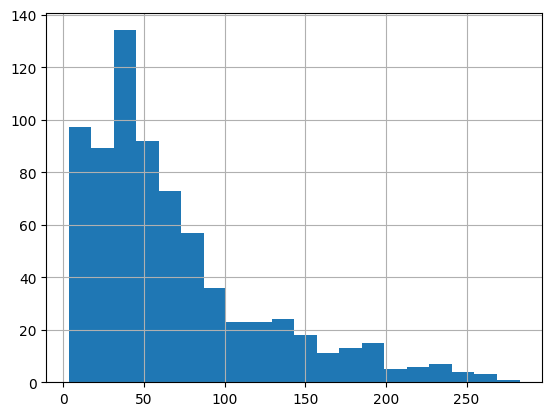

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50205.97


<Axes: >

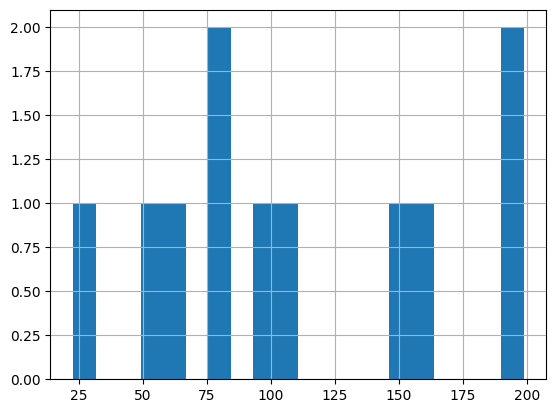

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='The Starless Crown, Rollins']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

floor dividing for n-fold
Cards found: 731
Total card age: 50205.97


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
212,Azure Compute Gallery,Azure Policy Enforcement – Some organizations ...,5955c1744fec96ecfbc714dfb3e684de,28.442321,28.442321,-28.442321,28.442321,0.723252,1,0,0,-28.442321
246,PP365,Engagement Tasks (table name ts_engagementtask...,df665245c67565ee54408cc4155cc9dd,7.310858,7.310858,-7.310858,7.310858,0.093480,1,0,0,-7.310858
194,pfSense,The name of a FreeBSD interface starts with th...,7c36c65aeb40df767dfcd7d9632cf31f,61.226621,43.251499,-61.226621,129.754496,0.285797,3,0,0,-61.226621
443,pfSense,pfSense software also transmits a unique and r...,ccbf802e0dee38559822abc0e0d06680,50.084375,43.251499,-61.226621,129.754496,0.285797,3,1,0,-50.084375
683,pfSense,SOHO stands for Small Office and Home Office N...,b715b57606dff08fcc76e732eafc3711,18.443500,43.251499,-61.226621,129.754496,0.285797,3,2,0,-18.443500
180,Vocab,"How to Sell a Haunted House, Hendrix\nTulle\nP...",c8404b20be2c59d64bc56fa8551eab2d,135.900894,60.442013,-135.900894,423.094092,0.853108,7,0,0,-135.900894
431,Vocab,Structured Credit Provides Portfolio Diversifi...,39cbed72ce7e08bfbd58454335ef70f7,73.149900,60.442013,-135.900894,423.094092,0.853108,7,1,0,-73.149900
671,Vocab,"How to Sell a Haunted House, Hendrix\nStollen ...",2f0f1d406aece7f1fd77835411449718,57.518811,60.442013,-135.900894,423.094092,0.853108,7,2,0,-57.518811
181,Vocab,"Something Rotten, Fforde\nZane Grey\n\nAn Amer...",4d056237b3f10871908a32ab2cd8b771,50.844680,60.442013,-135.900894,423.094092,0.853108,7,3,0,-50.844680
432,Vocab,"Well of Lost Plots, Fforde\nInveigle\nverb | i...",9fc881a68f1aa7c5604c358114142b61,37.288270,60.442013,-135.900894,423.094092,0.853108,7,4,0,-37.288270



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(520.2102306288441)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
65,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,282.862443,84.598527,-282.862443,3468.539606,0.640514,41,0,0,-282.862443
116,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,268.824243,78.954259,-268.824243,4500.392783,0.516464,57,0,0,-268.824243
59,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,266.558732,85.562041,-266.558732,1368.992651,0.564881,16,0,0,-266.558732
90,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,256.490392,80.929168,-256.490392,6150.616743,0.555094,76,0,0,-256.490392
253,Asynchronous Python,Timeouts\nTechniques like asyncio.wait_for() u...,c31a13ce25b1e193f61beaf84e6dffd8,252.423682,100.007928,-252.423682,1300.103065,0.295500,13,0,0,-252.423682
135,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,247.346827,75.087012,-247.346827,3378.915552,0.311583,45,0,0,-247.346827
156,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,245.929259,69.710788,-245.929259,2788.431524,0.346878,40,0,0,-245.929259
314,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,245.846287,85.562041,-266.558732,1368.992651,0.564881,16,1,0,-245.846287
53,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,239.023055,87.410161,-239.023055,1485.972733,0.948872,17,0,0,-239.023055
344,Python,"Q:\nHow can you use tqdm with file operations,...",70d79d8d31058fa7cb312f724aa1d578,238.404434,80.929168,-256.490392,6150.616743,0.555094,76,1,0,-238.404434


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.681'